# Permutation Feature Importance

In [88]:
import tensorflow as tf

# Commonly used modules
import numpy as np
import os
import sys

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import IPython
from six.moves import urllib

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline


print(tf.__version__)

2.3.4


In [89]:
(train_features, train_labels), (test_features, test_labels) = tf.keras.datasets.boston_housing.load_data()
features = [('CRIM', 'crime_rate'), ('ZN', 'residential_zone'),
            ('INDUS', 'prop_non-retail'), ('CHAS', 'river_adjacent'),
            ('NOX', 'NO_concentration'), ('RM', 'avg_rooms'),
            ('AGE', 'age'), ('DIS', 'employment_proximit'),
            ('RAD', 'radial_highways'), ('TAX', 'tax_rate'),
            ('PTRATIO', 'pupil-teacher_ratio'), ('B', 'prop_black'),
            ('LSTAT', 'lower_status_pop')]
df_train_features = pd.DataFrame(train_features, columns=[feature[0] for feature in features])
df_train_labels = pd.DataFrame({'MEDV': train_labels})
df = pd.concat((df_train_features, df_train_labels), axis=1)

In [90]:
# get per-feature statistics (mean, standard deviation) from the training set to normalize by
def normalize(np_array):
    array_mean = np.mean(np_array, axis=0)
    array_std = np.std(np_array, axis=0)
    return (np_array - array_mean) / array_std

X_train = normalize(train_features)
X_test = normalize(test_features)

In [91]:
# Numerical Variables
num_vars = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
           'TAX', 'PTRATIO', 'B', 'LSTAT']

# Categorical variables
cat_vars = ['CHAS']

X = df[num_vars + cat_vars]

X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.2, random_state=1337)

In [92]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(40, activation=tf.nn.relu, input_shape=[len(train_features[0])]),
        tf.keras.layers.Dense(20, activation=tf.nn.relu),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(), 
                  loss='mse',
                  metrics=['mae', 'mse'])
    return model

In [93]:
model = build_model()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
history = model.fit(train_features, train_labels, epochs=100, verbose=0,
                    validation_data = (test_features, test_labels),
                    callbacks=[early_stopping]
                   )

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

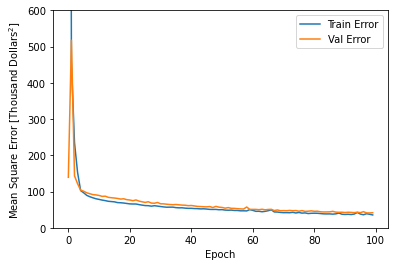

In [94]:
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [Thousand Dollars$^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.legend()
    plt.ylim([0,600])

plot_history()

In [64]:
mse_test = np.mean((np.squeeze(model.predict(test_features)) - test_labels)**2)
mse_test

30.00218287920229

In [65]:
features = [('CRIM', 'crime_rate'), ('ZN', 'residential_zone'),
            ('INDUS', 'prop_non-retail'), ('CHAS', 'river_adjacent'),
            ('NOX', 'NO_concentration'), ('RM', 'avg_rooms'),
            ('AGE', 'age'), ('DIS', 'employment_proximity'),
            ('RAD', 'radial_highways'), ('TAX', 'tax_rate'),
            ('PTRATIO', 'pupil-teacher_ratio'), ('B', 'prop_black'),
            ('LSTAT', 'lower_status_pop')]
df = pd.DataFrame(test_features, columns=[feature[0] for feature in features])

In [66]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,18.08460,0.0,18.10,0.0,0.679,6.434,100.0,1.8347,24.0,666.0,20.2,27.25,29.05
1,0.12329,0.0,10.01,0.0,0.547,5.913,92.9,2.3534,6.0,432.0,17.8,394.95,16.21
2,0.05497,0.0,5.19,0.0,0.515,5.985,45.4,4.8122,5.0,224.0,20.2,396.90,9.74
3,1.27346,0.0,19.58,1.0,0.605,6.250,92.6,1.7984,5.0,403.0,14.7,338.92,5.50
4,0.07151,0.0,4.49,0.0,0.449,6.121,56.8,3.7476,3.0,247.0,18.5,395.15,8.44


In [67]:
df_perturb = df.copy()

In [68]:
df_perturb['CRIM'] = df_perturb['CRIM'].sample(frac=1.0).values

In [69]:
df_perturb.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,14.33370,0.0,18.10,0.0,0.679,6.434,100.0,1.8347,24.0,666.0,20.2,27.25,29.05
1,1.35472,0.0,10.01,0.0,0.547,5.913,92.9,2.3534,6.0,432.0,17.8,394.95,16.21
2,0.03705,0.0,5.19,0.0,0.515,5.985,45.4,4.8122,5.0,224.0,20.2,396.90,9.74
3,0.01501,0.0,19.58,1.0,0.605,6.250,92.6,1.7984,5.0,403.0,14.7,338.92,5.50
4,0.09744,0.0,4.49,0.0,0.449,6.121,56.8,3.7476,3.0,247.0,18.5,395.15,8.44


In [70]:
np.mean((np.squeeze(model.predict(df_perturb.values)) - test_labels)**2)

33.33827554460172

In [71]:
result = []

for feature in features:
  df_perturb = df.copy()
  # shuffle feature values
  df_perturb[feature[0]] = df_perturb[feature[0]].sample(frac=1.0).values

  mse_perturb = np.mean((np.squeeze(model.predict(df_perturb.values)) - test_labels)**2)
  # result[feature] = [mse_perturb]
  result.append({'feature_name': feature[0],
                 'feature': feature[1],
                 'score': mse_perturb - mse_test})

df_pfi = pd.DataFrame(result).sort_values(by='score',
                                          ascending=False)
df_pfi

,feature_name,feature,score
12,LSTAT,lower_status_pop,82.914677
9,TAX,tax_rate,30.496683
8,RAD,radial_highways,17.189064
2,INDUS,prop_non-retail,11.840635
6,AGE,age,11.711357
7,DIS,employment_proximity,2.671644
10,PTRATIO,pupil-teacher_ratio,2.642333
11,B,prop_black,1.987297
0,CRIM,crime_rate,1.811401
5,RM,avg_rooms,1.533502


## Permutation Feature Importance in sci-kit learn

In [76]:
(train_features, train_labels), (test_features, test_labels) = tf.keras.datasets.boston_housing.load_data()
features = [('CRIM', 'crime_rate'), ('ZN', 'residential_zone'),
            ('INDUS', 'prop_non-retail'), ('CHAS', 'river_adjacent'),
            ('NOX', 'NO_concentration'), ('RM', 'avg_rooms'),
            ('AGE', 'age'), ('DIS', 'employment_proximit'),
            ('RAD', 'radial_highways'), ('TAX', 'tax_rate'),
            ('PTRATIO', 'pupil-teacher_ratio'), ('B', 'prop_black'),
            ('LSTAT', 'lower_status_pop')]
df_train_features = pd.DataFrame(train_features, columns=[feature[0] for feature in features])
df_train_labels = pd.DataFrame({'MEDV': train_labels})
df = pd.concat((df_train_features, df_train_labels), axis=1)

df.CHAS = df.CHAS.apply(lambda x: 'T' if x==1.0 else 'F')

In [77]:
# Numerical Variables
num_vars = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
           'TAX', 'PTRATIO', 'B', 'LSTAT']

# Categorical variables
cat_vars = ['CHAS']

X = df[num_vars + cat_vars]

# Label
y = df['MEDV']

In [79]:
# Create models
mlp_reg = MLPRegressor(hidden_layer_sizes=[300, 200, 100],
                       max_iter=700)

# Create pipeline
transformer = ColumnTransformer([
    ('numerical', MinMaxScaler(feature_range=(-1,1)), num_vars),
    ('categorical', OneHotEncoder(), cat_vars),
])

mlp_pipeline = Pipeline(steps=[
    ('transform', transformer),
    ('model', mlp_reg)
])

# Create dataset
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.2, random_state=1337)

mlp_pipeline.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('numerical',
                                                  MinMaxScaler(feature_range=(-1,
                                                                              1)),
                                                  ['CRIM', 'ZN', 'INDUS', 'NOX',
                                                   'RM', 'AGE', 'DIS', 'RAD',
                                                   'TAX', 'PTRATIO', 'B',
                                                   'LSTAT']),
                                                 ('categorical',
                                                  OneHotEncoder(),
                                                  ['CHAS'])])),
                ('model',
                 MLPRegressor(hidden_layer_sizes=[300, 200, 100],
                              max_iter=700))])

In [80]:
model_mse_error = np.sqrt(np.mean((mlp_pipeline.predict(X_test) - y_test)**2))
print(f'Mean squared error of MLP model: {model_mse_error}')

Mean squared error of MLP model: 2.893469319134751


In [81]:
mlp_pipeline.score(X_test, y_test)

0.9295746160970157

In [82]:
from sklearn.inspection import permutation_importance
r = permutation_importance(mlp_pipeline, X_test, y_test,
                           n_repeats=30,
                           random_state=0)

In [85]:
boston_features = num_vars + cat_vars

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{boston_features[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

LSTAT   0.810 +/- 0.185
RM      0.491 +/- 0.076
DIS     0.170 +/- 0.035
AGE     0.148 +/- 0.038
RAD     0.117 +/- 0.034
NOX     0.115 +/- 0.028
TAX     0.115 +/- 0.026
CRIM    0.052 +/- 0.013
PTRATIO 0.051 +/- 0.013
INDUS   0.050 +/- 0.023


In [86]:
from sklearn.inspection import permutation_importance
r = permutation_importance(mlp_pipeline, X_test, y_test,
                           n_repeats=10,
                           random_state=0)

In [87]:
boston_features = num_vars + cat_vars

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{boston_features[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

LSTAT   0.870 +/- 0.187
RM      0.476 +/- 0.064
DIS     0.174 +/- 0.034
AGE     0.162 +/- 0.041
NOX     0.125 +/- 0.026
TAX     0.123 +/- 0.032
RAD     0.119 +/- 0.035
INDUS   0.052 +/- 0.020
CRIM    0.051 +/- 0.012
PTRATIO 0.049 +/- 0.012
ZN      0.020 +/- 0.009
CHAS    0.006 +/- 0.003


Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License